In [28]:
!pip install transformers


In [29]:
pip install datasets


In [30]:
pip install tensorflow

In [31]:
import pandas as pd
from transformers import TFAutoModel , AutoTokenizer
from datasets import load_dataset
from transformers import DistilBertTokenizer
from sklearn.model_selection import train_test_split
import tensorflow as tf


In [32]:
model = TFAutoModel.from_pretrained("bert-base-uncased")

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

In [33]:
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

In [34]:
input = tokenizer(['HR Dashboard'], padding = True, truncation = True,
                  return_tensors ='tf')
input

{'input_ids': <tf.Tensor: shape=(1, 4), dtype=int32, numpy=array([[  101, 17850, 24923,   102]], dtype=int32)>, 'token_type_ids': <tf.Tensor: shape=(1, 4), dtype=int32, numpy=array([[0, 0, 0, 0]], dtype=int32)>, 'attention_mask': <tf.Tensor: shape=(1, 4), dtype=int32, numpy=array([[1, 1, 1, 1]], dtype=int32)>}

In [35]:
output = model(input)
output

TFBaseModelOutputWithPoolingAndCrossAttentions(last_hidden_state=<tf.Tensor: shape=(1, 4, 768), dtype=float32, numpy=
array([[[-0.3039519 , -0.0305858 ,  0.00400882, ..., -0.4847506 ,
          0.34516576,  0.5188402 ],
        [ 0.35778362, -0.38408604,  0.37003654, ..., -0.61620265,
          0.59948844, -0.5405039 ],
        [-0.3738274 , -0.60607785, -0.2814977 , ...,  0.23797421,
          0.1242699 , -0.47484154],
        [ 0.9056071 , -0.07485908, -0.24208027, ...,  0.15136041,
         -0.7880484 , -0.16790864]]], dtype=float32)>, pooler_output=<tf.Tensor: shape=(1, 768), dtype=float32, numpy=
array([[-0.92287546, -0.35723177, -0.3496863 ,  0.8278717 ,  0.16023648,
        -0.27237093,  0.95286185,  0.23496045, -0.16329418, -0.99997896,
        -0.42060584,  0.7907553 ,  0.9824214 ,  0.12147571,  0.9344821 ,
        -0.7458304 , -0.42436796, -0.6028366 ,  0.40586725, -0.8018198 ,
         0.7044959 ,  0.9990763 ,  0.33071578,  0.42010006,  0.43133718,
         0.89415425, -0.76

In [36]:
emotions = pd.read_csv('/content/layoffs.csv')

In [37]:
emotions

,location,industry,total_laid_off,percentage_laid_off,date,country
0,Hamburg,Consumer,400.0,NaN,1/11/2024,Germany
1,Tel Aviv,Consumer,300.0,0.10,1/11/2024,Israel
2,SF Bay Area,Consumer,170.0,0.17,1/11/2024,United States
3,Bengaluru,Marketing,125.0,0.05,1/11/2024,India
4,New York City,Media,100.0,0.05,1/11/2024,United States
...,...,...,...,...,...,...
3308,Los Angeles,Travel,NaN,1.00,3/16/2020,United States
3309,Los Angeles,Transportation,8.0,0.10,3/13/2020,United States
3310,SF Bay Area,Consumer,6.0,0.75,3/13/2020,United States
3311,Los Angeles,Retail,20.0,0.40,3/12/2020,United States


In [38]:
def tokenize(batch) :
  return tokenizer(batch["text"], padding=True, truncation=True)


In [39]:
# Load DistilBERT tokenizer
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

# Define a function to tokenize a single text
def tokenize_text(text):
    return tokenizer.encode_plus(text,
                                  add_special_tokens=True,
                                  max_length=512,
                                  padding='max_length',
                                  truncation=True,
                                  return_attention_mask=True,
                                  return_tensors='pt')

# Apply the function to each row of your DataFrame
emotions_encoded = emotions['country'].apply(tokenize_text)

# Now you have a Series of tokenized representations


In [40]:
emotions_encoded

0       [input_ids, attention_mask]
1       [input_ids, attention_mask]
2       [input_ids, attention_mask]
3       [input_ids, attention_mask]
4       [input_ids, attention_mask]
                   ...             
3308    [input_ids, attention_mask]
3309    [input_ids, attention_mask]
3310    [input_ids, attention_mask]
3311    [input_ids, attention_mask]
3312    [input_ids, attention_mask]
Name: country, Length: 3313, dtype: object

In [41]:
import tensorflow as tf

class BERTForClassification(tf.keras.Model):

    def __init__(self, bert_model, num_classes):
        super().__init__()
        self.bert = bert_model
        self.fc = tf.keras.layers.Dense(num_classes, activation='softmax')

    def call(self, inputs):
        x = self.bert(inputs)[1]
        return self.fc(x)



In [42]:
# Features
X = emotions[['industry', 'country', 'date']]

# Labels
y = emotions['total_laid_off']

# Splitting the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.8, random_state=42)

# Now you can use X_train and y_train for training


In [43]:
classifier = BERTForClassification(model, num_classes=6)

classifier.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)


In [44]:
# Check unique values in the 'industry' column
print("Unique values in 'industry':", X_train['industry'].unique())

# Check unique values in the 'country' column
print("Unique values in 'country':", X_train['country'].unique())


Unique values in 'industry': ['Finance' 'Security' 'Media' 'Consumer' 'Healthcare' 'Other' 'Retail'
 'Support' 'Marketing' 'Real Estate' 'Travel' 'Energy' 'Hardware'
 'Recruiting' 'Product' 'Fitness' 'Logistics' 'Data' 'Education'
 'Transportation' 'Food' 'Crypto' 'Legal' 'Sales' 'Infrastructure' 'HR'
 'Aerospace' 'Construction' 'Manufacturing' 'AI']
Unique values in 'country': ['Switzerland' 'United States' 'Canada' 'Sweden' 'Singapore' 'Israel'
 'India' 'Germany' 'Australia' 'United Kingdom' 'Nigeria' 'China'
 'Finland' 'France' 'Brazil' 'Ireland' 'Bulgaria' 'Seychelles' 'Indonesia'
 'New Zealand' 'Bahrain' 'Japan' 'Netherlands' 'Belgium' 'Mexico' 'Turkey'
 'Poland' 'Uruguay' 'Myanmar' 'Ghana' 'United Arab Emirates' 'Denmark'
 'Estonia' 'Norway' 'Hong Kong' 'Spain' 'Vietnam']


In [45]:
# Check if the columns exist before applying transformations
if 'percentage_laid_off' in emotions.columns:
    emotions['total_laid_off'] = emotions['percentage_laid_off'].apply(lambda x: 1 if x == 'Yes' else 0)
else:
    print("Column 'percentage_laid_off' not found in DataFrame.")

In [46]:
emotions.head(4)

,location,industry,total_laid_off,percentage_laid_off,date,country
0,Hamburg,Consumer,0,NaN,1/11/2024,Germany
1,Tel Aviv,Consumer,0,0.10,1/11/2024,Israel
2,SF Bay Area,Consumer,0,0.17,1/11/2024,United States
3,Bengaluru,Marketing,0,0.05,1/11/2024,India


array([[<Axes: title={'center': 'total_laid_off'}>,
        <Axes: title={'center': 'percentage_laid_off'}>]], dtype=object)

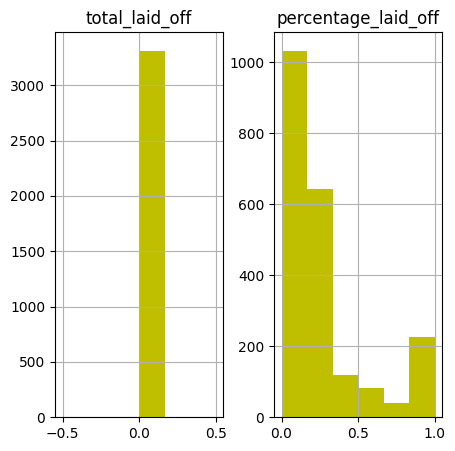

In [47]:
  emotions.hist(bins = 6, figsize = (5,5), color = 'y')

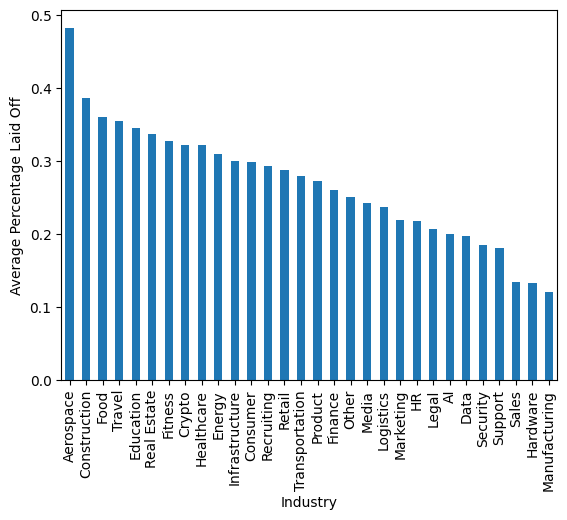

In [48]:
import matplotlib.pyplot as plt
emotions.groupby('industry')['percentage_laid_off'].mean().sort_values(ascending=False).plot(kind='bar')
plt.xlabel('Industry')
_ = plt.ylabel('Average Percentage Laid Off')

<Axes: xlabel='industry'>

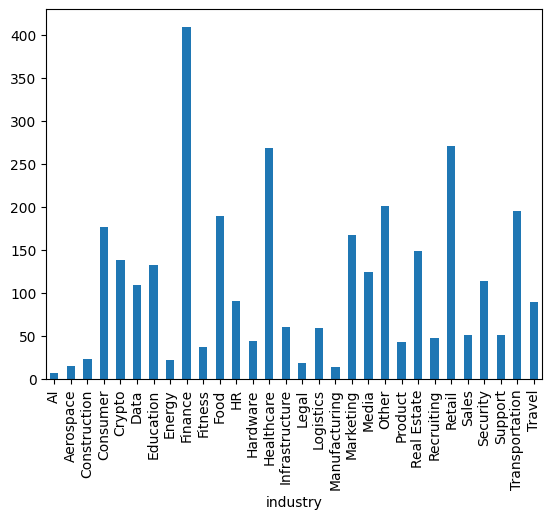

In [49]:
emotions.groupby('industry')['location'].count().plot(kind='bar')

In [50]:
import tensorflow as tf

# Select only numeric features for X_train
numeric_features = X_train.select_dtypes(include=['number'])

# Convert DataFrame to TensorFlow Dataset
train_dataset = tf.data.Dataset.from_tensor_slices((dict(numeric_features), y_train))

# Batch the dataset
batch_size = 32
train_dataset = train_dataset.batch(batch_size)


In [52]:
import tensorflow as tf

# Convert DataFrame to TensorFlow Dataset
train_dataset = tf.data.Dataset.from_tensor_slices((dict(X_train), y_train))

# Batch the dataset
batch_size = 32
train_dataset = train_dataset.batch(batch_size)


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0, 1, 2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


Epoch 1/8
78/78 - 3s - loss: 0.1774 - accuracy: 0.9952 - val_loss: 0.0025 - val_accuracy: 1.0000 - 3s/epoch - 37ms/step
Epoch 2/8
78/78 - 1s - loss: 0.0014 - accuracy: 1.0000 - val_loss: 6.6636e-04 - val_accuracy: 1.0000 - 758ms/epoch - 10ms/step
Epoch 3/8
78/78 - 1s - loss: 4.9125e-04 - accuracy: 1.0000 - val_loss: 3.2156e-04 - val_accuracy: 1.0000 - 812ms/epoch - 10ms/step
Epoch 4/8
78/78 - 1s - loss: 2.5131e-04 - accuracy: 1.0000 - val_loss: 1.8880e-04 - val_accuracy: 1.0000 - 1s/epoch - 13ms/step
Epoch 5/8
78/78 - 1s - loss: 1.6844e-04 - accuracy: 1.0000 - val_loss: 1.2186e-04 - val_accuracy: 1.0000 - 797ms/epoch - 10ms/step
Epoch 6/8
78/78 - 1s - loss: 1.0793e-04 - accuracy: 1.0000 - val_loss: 8.5717e-05 - val_accuracy: 1.0000 - 650ms/epoch - 8ms/step
Epoch 7/8
78/78 - 1s - loss: 7.6973e-05 - accuracy: 1.0000 - val_loss: 6.3240e-05 - val_accuracy: 1.0000 - 1s/epoch - 13ms/step
Epoch 8/8
78/78 - 1s - loss: 5.7925e-05 - accuracy: 1.0000 - val_loss: 4.8856e-05 - val_accuracy: 1.0000 

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1029: UndefinedMetricWarning: No positive s

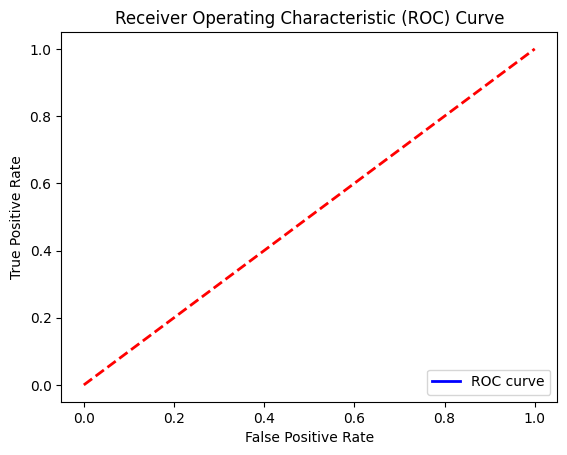

In [53]:
import pandas as pd
import numpy as np
import missingno as msno
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

# Convert 'percentage_laid_off' to binary labels
emotions['total_laid_off'] = emotions['percentage_laid_off'].apply(lambda x: 1 if x == 'Yes' else 0)

# Drop unnecessary columns
X = emotions.drop(columns=['percentage_laid_off'])
y = emotions['total_laid_off']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# Define categorical and numerical columns
categorical_cols = ['location', 'industry', 'date', 'country']  # Assuming these are categorical columns
numerical_cols = [col for col in X_train.columns if col not in categorical_cols]

# Create a column transformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),
        ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), categorical_cols)
    ],
    remainder='passthrough'
)

# Preprocess the data
X_train_preprocessed = preprocessor.fit_transform(X_train)
X_test_preprocessed = preprocessor.transform(X_test)

# Reshape target variables
y_train = np.array(y_train).reshape(-1, 1)
y_test = np.array(y_test).reshape(-1, 1)

# Initialize the neural network model
model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train_preprocessed.shape[1],)),
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train_preprocessed, y_train, epochs=8, batch_size=32, validation_data=(X_test_preprocessed, y_test), verbose=2)

# Predict on the test set
y_pred_prob = model.predict(X_test_preprocessed)
y_pred_classes = (y_pred_prob > 0.5).astype(int)

# Calculate evaluation metrics
accuracy = accuracy_score(y_test, y_pred_classes)
precision = precision_score(y_test, y_pred_classes)
recall = recall_score(y_test, y_pred_classes)
f1 = f1_score(y_test, y_pred_classes)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)

# Plot ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve')
plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

